In [ ]:
!rm -rf master.zip
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2025-05-19 02:33:34--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.138.176, 3.5.138.42, 52.219.171.88, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.138.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  17.0MB/s    in 1.5s    

2025-05-19 02:33:36 (17.0 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2025-05-19 02:33:36--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.138.176, 3.5.138.42, 52.219.171.88, ..

In [ ]:
# from https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
images, labels = load_mnist('.')
Y = labels.reshape(-1, 1)
X = images
X.shape

(60000, 784)

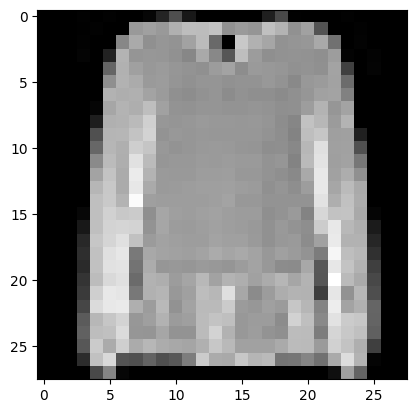

In [ ]:
plt.imshow(X[18].reshape(28, 28), cmap='grey')

In [ ]:
layers = (784, 30, 10)
# no of neurons in each layer

weight_mats = []
biases = []

for l_1, l in zip(layers, layers[1:]):
  weight_mats.append(np.random.randn(l, l_1))
  biases.append(np.random.randn(l, 1))

def sigmoid(x): # x is a vector
  return 1 / (1 + np.exp(-x))


def forward(x): # x is a vector of length 784
  a_vals = [x]
  z_vals = []
  for w, b in zip(weight_mats, biases):
    z = w @ x + b
    z_vals.append(z)
    x = sigmoid(z)
    a_vals.append(x)
  return x, z_vals, a_vals

In [ ]:
images, labels = load_mnist('.', kind='t10k')
test_y = labels.reshape(-1, 1)
test_x = images
test_x.shape

pred, xx, yy = forward(test_x.transpose())
def get_max_val(col):
  mv = max(col)
  for i, v in enumerate(col):
    if v == mv:
      return i

pred_i = np.apply_along_axis(get_max_val, 0, pred).reshape(-1, 1)

def print_test_accuracy():
  pred, xx, yy = forward(test_x.transpose())
  pred_i = np.apply_along_axis(get_max_val, 0, pred).reshape(-1, 1)
  print(f'Accuracy: {(pred_i == test_y).sum()} / 10,000')

<ipython-input-6-7e9aa2b01f42>:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [ ]:
# training
BATCH_SIZE = 10
LEARNING_RATE = 0.001

STOP_LOSS = 0.2 # stop when loss is less than this value

break_signal = False

for epoch in range(1000):
  if break_signal:
    break
  print(f'EPOCH {epoch}')

  if epoch % 10 == 0:
    print_test_accuracy()

  index = np.arange(X.shape[0])
  np.random.shuffle(index)
  x_shuffled = X[index]
  y_shuffled = Y[index]
  for i in range(0, X.shape[0], BATCH_SIZE):
    x = x_shuffled[i:i+BATCH_SIZE].transpose()
    y = y_shuffled[i:i+BATCH_SIZE]
    y = np.array([[1 if i == n else 0 for i in range(10)] for n in y.flatten()]).transpose()

    p, z_vals, a_vals = forward(x)

    # print loss if first run of this batch
    if i == 0:
      loss = (p - y) ** 2
      loss = loss.sum() / BATCH_SIZE
      if loss < STOP_LOSS:
        break_signal = True
        break
      print(f'LOSS: {loss}')

    del_C = p - y
    z_L = z_vals[-1]
    sigma_dash_z_L = sigmoid(z_L) * (1 - sigmoid(z_L))

    deltas = [0] * (len(layers) - 1)
    deltas[-1] = del_C * sigma_dash_z_L
    for i in range(2, len(deltas) + 1):
      w_T = weight_mats[-i + 1].transpose()
      delta_l_1 = deltas[-i + 1]
      sigma_dash_z_L = sigmoid(z_vals[-i]) * (1 - sigmoid(z_vals[-i]))
      deltas[-i] = (w_T @ delta_l_1) * sigma_dash_z_L
    for w, delta, act, i in zip(weight_mats, deltas, a_vals, range(len(weight_mats))):
      # find del w
      del_w = delta @ act.transpose()
      w -= LEARNING_RATE * del_w
      weight_mats[i] = w
    for b, delta, i in zip(biases, deltas, range(len(biases))):
      del_b = delta.sum(axis=1, keepdims=True) / BATCH_SIZE
      b -= LEARNING_RATE * del_b
      biases[i] = b

EPOCH 0


<ipython-input-6-7e9aa2b01f42>:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 1194 / 10,000
LOSS: 4.796047960342215
EPOCH 1
LOSS: 0.9599673881519311
EPOCH 2
LOSS: 0.959719022015968
EPOCH 3
LOSS: 0.5667831081529868
EPOCH 4
LOSS: 0.9136041655313963
EPOCH 5
LOSS: 0.8693551634240132
EPOCH 6
LOSS: 0.615197750530518
EPOCH 7
LOSS: 0.723399201296482
EPOCH 8
LOSS: 0.908446177415696
EPOCH 9
LOSS: 0.6366752426291196
EPOCH 10
Accuracy: 5476 / 10,000
LOSS: 0.49017132898427784
EPOCH 11
LOSS: 0.5256432832937203
EPOCH 12
LOSS: 0.3906718851042738
EPOCH 13
LOSS: 0.6839836131324429
EPOCH 14
LOSS: 0.47094616335994843
EPOCH 15
LOSS: 0.6722672405891714
EPOCH 16
LOSS: 0.5071650504070904
EPOCH 17
LOSS: 0.7029712781776025
EPOCH 18
LOSS: 0.7049832566933096
EPOCH 19
LOSS: 0.4420563637883001
EPOCH 20
Accuracy: 6553 / 10,000
LOSS: 0.35332980060135116


KeyboardInterrupt: 

In [ ]:
p, a, b = forward(X[45])
p.shape

<ipython-input-6-7e9aa2b01f42>:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(10, 30)

In [ ]:
## TIME TO USE TORCH FFS
import torch

In [ ]:
layers = (784, 30, 10)
# no of neurons in each layer

weight_mats = []
biases = []

for l_1, l in zip(layers, layers[1:]):
  weight_mats.append(torch.randn(l, l_1, dtype=torch.float, requires_grad=True))
  biases.append(torch.randn(l, 1, dtype=torch.float, requires_grad=True))

def sigmoid(x): # x is a vector
  return 1 / (1 + torch.exp(-x))


def forward(x): # x is a vector of length 784
  for w, b in zip(weight_mats, biases):
    z = w @ x + b
    x = sigmoid(z)
  return x

In [ ]:
torch.autograd.set_detect_anomaly(True)
x_train = torch.tensor(X, dtype=torch.float)
y_train = torch.tensor(Y, dtype=torch.float)
# training
BATCH_SIZE = 10
LEARNING_RATE = 0.001

for epoch in range(100):
  print(f'EPOCH {epoch}')

  index = np.arange(X.shape[0])
  np.random.shuffle(index)
  x_shuffled = x_train[index]
  y_shuffled = y_train[index]
  for i in range(0, X.shape[0], BATCH_SIZE):
    x = x_shuffled[i:i+BATCH_SIZE].transpose(0,1)
    y = y_shuffled[i:i+BATCH_SIZE]
    y = torch.tensor([[1 if i == n else 0 for i in range(10)] for n in y.flatten()]).transpose(0,1)

    # forward pass
    res = [x]
    for w, b in zip(weight_mats, biases):
      res.append(sigmoid(w @ res[len(res)-1] + b))
      # x = sigmoid(z)

    cost_mat = (res[len(res) - 1] - y) ** 2
    C = cost_mat.sum() / BATCH_SIZE
    if i == 0:
      print(f'LOSS: {C}')

    C.backward()
    with torch.no_grad():
      for w, b in zip(weight_mats, biases):
        # print(w.grad.shape, w.shape, b.grad.shape, b.shape)
        w -= LEARNING_RATE * w.grad
        b -= LEARNING_RATE * b.grad
        print(w.grad)
        # w.grad = None
        # b.grad = None


EPOCH 0
LOSS: 3.928499937057495


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Error detected in ExpBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    self._run_once()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
    handle._run()
  File "/usr/lib/python3.11/

RuntimeError: Function 'ExpBackward0' returned nan values in its 0th output.